# TP 3: Zoom d'images par minimisation de la variation totale



Dans ce TP, nous allons considérer une méthode d'optimisation pour zoomer des
images. Nous considèrerons un modèle d'échantillonnage simple. \'Etant donnée une
image de départ $u$, de taille $KN\times KN$, l'image sous-échantillonnée,
dans un rapport $K$,  $v$ est définie par
$$v_{i,j}=\frac{1}{K^2} \sum_{k,l=0}^{K-1} u_{Ki+k,Kj+l},
$$
pour $(i,j)\in \{0,\ldots,N-1\}^2$. On note l'opérateur d'échantillonnage ainsi
défini $Q$. On a donc $v=Q(u)$.

On notera 
$${\mathcal C}=\{w\in{\mathbb R}^{(KN)^2}, Q(w)=v\}.
$$

On sait donc que $u\in {\mathcal C}$, c'est la seule information dont nous sommes sûr
concernant $u$.

Pour définir une méthode d'optimisation permettant de zoomer une image $u$,
il est donc naturel de considérer le problème:
$$(P):\left\{\begin{array}{l}
\mbox{minimiser } E(w) \\ 
\mbox{sous la contrainte } w\in{\mathcal C},
\end{array}\right.
$$
pour une énergie $E$ bien choisie.

Nous considèrerons dans cet exercice la minimisation d'une approximation différentiable de la variation
totale. Pour cela, nous définissons 
$$\nabla w_{i,j}=\left(\begin{array}{c}
(D_x w)_{i,j} \\
(D_y w)_{i,j}
\end{array}
\right)=\left(\begin{array}{c}
w_{i+1,j}-w_{i,j} \\
w_{i,j+1}-w_{i,j}
\end{array}
\right)
$$
pour $(i,j)\in\{0,\ldots, KN-1\}^2$ (on supposera que $w$ est périodisée en
dehors de son support).

Par ailleurs, nous approximerons le module du gradient, dans la variation totale, par
$$\varphi_\beta (|\nabla w_{i,j}|^2),
$$
avec
$$\varphi_\beta (t)=\sqrt{t+\beta},
$$
pour $\beta>0$. En pratique, on prendra $\beta=0.01$. L'approximation de la variation totale est alors définie par
$$E_\beta(w)=\sum_{i,j=0}^{KN-1} \varphi_\beta \left( |\nabla w_{i,j}|^2 \right).
$$


## Chargement de bibliothèques, chargement d'une image et affichage d'une image

In [1]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




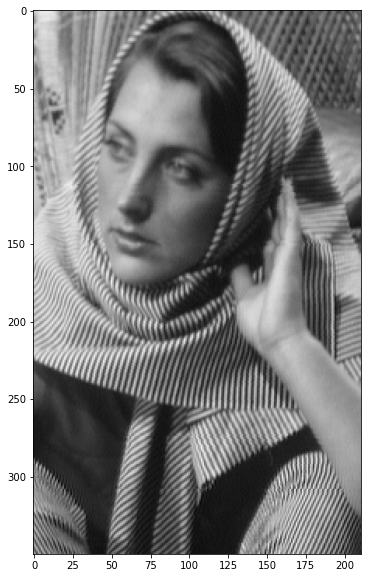

In [18]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:511]    # image de taille moyenne
#u = u[100:140,300:331]   # Toute petite image pour debugger

plt.figure(figsize = (10,10))
plt.imshow(u,cmap='gray')
plt.show()

## Fonction calculant l'échantillonnage

### Question 5

L'algorithme du gradient projeté permettant de résoudre le problème $\left(P\right)$ est donné par:
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<p><font color = "blue"> <b>Algorithme du gradient avec projection</b> </font><br></p>
<b>Entrée :</b> $v$, N, beta<br>  
<b>Sortie :</b> Une approximation de la solution de $\left(P\right)$ : $w^*$<br>
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Initialisation de $w \leftarrow K^2Q^*(v)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; pas $\leftarrow \frac{1}{L} = \frac{\sqrt{\beta}}{8} $<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Pour i entre 0 et N-1 faire : <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $d \leftarrow \nabla E(w)$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow w-pas *d$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow P_{\mathcal{C}}(w)$

avec $L = \frac{8}{\sqrt{\beta}}$ d'après le [cours](https://www.math.univ-toulouse.fr/~fmalgouy/MMIP/lecture5.pdf) disponible ci-dessus.

In [3]:
def echantillonne_image(inp,K,adjoint):
    sx , sy = np.shape(inp)  
    
    if adjoint==0:
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += inp[K*x+k,K*y+l]
                out[x,y]=tmp
                
    else:
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= inp[x,y]
           
    
    return out/(K*K)

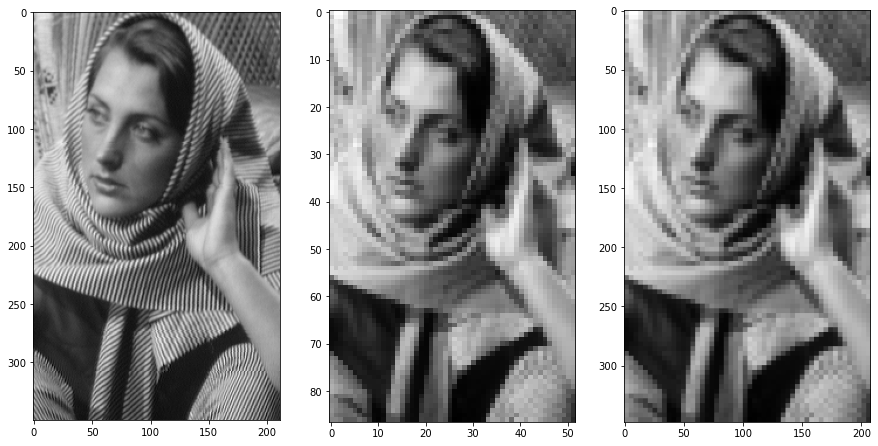

In [4]:
K=4
v = echantillonne_image(u,K,0)
w = echantillonne_image(v,K,1)

plt.figure(figsize = (15,30))
plt.subplot(1,3,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(v,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(w,cmap='gray')



## Fonction calculant itérativement le minimiseur

In [37]:
def grad_x(img, adjoint):
    sx , sy = np.shape(img)
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else:
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def grad_y(img, adjoint):
    sx , sy = np.shape(img)
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y

def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
################################
def phi(img,beta):
    
    return np.sqrt(img+beta)

def phi_p(img,beta):

    return np.sqrt(1/(4*(img+beta)))
################################
def grad_TV(out,beta):
    tmpx = grad_x(out,0)
    tmpy = grad_y(out,0)
    
    tmp = phi_p(tmpx*tmpx+tmpy*tmpy,beta)
    
    tmpx1 = grad_x(tmp*tmpx,1)
    tmpy1 = grad_y(tmp*tmpy,1)
    
    grad = 2 * (tmpx1 + tmpy1) 
    
    return grad
 
def TV(out,beta):
    sx , sy = np.shape(out)
    tmpx = grad_x(out,0)
    tmpy = grad_y(out,0)
    
    tmp = phi(tmpx*tmpx+tmpy*tmpy,beta)
 
    return np.sum(np.abs(tmp))/(sx*sy)
################################


def projection(img,v,K):
    tmp = echantillonne_image(img,K,0)
    tmp1 = (K*K)*echantillonne_image(tmp-v,K,1)

    return img - tmp1

################################
  
def zoom_TV(v,K,nbIter):
    beta = 1
    pas = beta/4
    func = []

    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_TV(out,beta)
        out = out - pas * d
        out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', TV(out,beta) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        func += [TV(out,beta)]
        
    return out,func

### Question 6

$\bullet$ **<code><font color = "blue">echantillonne_image</font></code>**<br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```inp``` : une image $u$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```K``` : le facteur K de sous-échantillonnage<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```adjoint``` : variable prenant une valeur logique 0 ou 1<br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ si ```adjoint``` prend la valeur 0, la fonction calcule de l'opérateur de sous-échantillonnage suivant $Q : u_{i,j}\mapsto \frac{1}{K^2} \sum_{k,l = 0}^{K-1}u_{Ki+k, Kj+l} $, $\forall (i,j) \in \left\{0, ..., \left[\frac{N-1}{K}\right]\right\}^2 $, $\forall (k,l) \in \left\{0, ..., K-1\right\}^2 $ renvoyant une image $v$ sous-échantillonnée de taille $\left [\frac{N}{K}\right]\times\left [\frac{N}{K}\right]$ <br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ si ```adjoint``` prend la valeur 1, la fonction calcule l'opérateur de sur-échantillonnage suivant $Q^* : u_{Ki+k,Kj+l}\mapsto \frac{1}{K^2} u_{i,j} $, $\forall (i,j) \in \left\{0, ..., N-1\right\}^2 $, $\forall (k,l) \in \left\{0, ..., K-1\right\}^2 $ renvoyant une image $v$ sur-échantillonnée de taille $KN\times KN$<br>
<br>

$\bullet$ **<code><font color = "blue">grad_x</font></code>**<br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```img``` : Une image $w$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```adjoint``` : variable prenant une valeur logique 0 ou 1<br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ Si ```adjoint``` prend la valeur 0,la fonction retourne le gradient de $w$ selon la direction $x$, $(D_x w)_{i,j} = w_{i+1,j}-w_{i,j} $ <br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ Si ```adjoint``` prend la valeur 1, la fonction retourne l'adjoint du gradient de w selon la direction $x$, $(D_x^* w)_{i,j} = w_{i-1,j}-w_{i,j} $ <br>

<br>
De manière analogue,

$\bullet$ **<code><font color = "blue">grad_y</font></code>** <br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```img``` : Une image $w$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```adjoint``` : variable prenant une valeur logique 0 ou 1<br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ Si ```adjoint``` prend la valeur 0, la fonction retourne le gradient de $w$ selon la direction $y$, $(D_y w)_{i,j} = w_{i,j+1}-w_{i,j} $<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ Si ```adjoint``` prend la valeur 1, l'adjoint du gradient de w selon la direction $y$, $(D_y^* w)_{i,j} = w_{i,j-1}-w_{i,j} $ <br>
<br>
<br>

$\bullet$ **<code><font color = "blue">verifie_grad_x(in1,in2)</font></code>**  et **<code><font color = "blue">verifie_grad_y(in1,in2)</font></code>**<br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```in1``` : Une première image $u_1$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```in2``` : Une deuxième image $u_2$<br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```verifie_grad_x(in1,in2)``` renvoie une valeur logique ```True``` ou ```False``` vérifiant que $\langle\ D_x in_1,in_2\rangle = \langle\ in_1,D^*_x in_2 \rangle$ <br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```verifie_grad_y(in1,in2)``` renvoie une valeur logique ```True``` ou ```False``` vérifiant que $\langle\ D_y in_1,in_2\rangle = \langle\ in_1,D^*_y in_2\rangle$  <br>
<br>
<br>

$\bullet$ **<code><font color = "blue">phi</font></code>**<br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```img``` : Une image $w$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```beta``` : une variable $\beta$ <br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $\varphi_{\beta}(w) = \sqrt{w+\beta}$<br>
<br>


$\bullet$ **<code><font color = "blue">phi_p</font></code>** <br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```img``` : Une image $w$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```beta``` : une variable $\beta$ <br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $\varphi'_{\beta}(w) = \frac{1}{2\sqrt{w+\beta}}$<br>
<br>
<br>

$\bullet$ **<code><font color = "blue">grad_TV</font></code>** <br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```out``` : Une image $w$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```beta``` : une variable $\beta$ <br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $\nabla E(w) = 2 \left(D_x^*(X)+D_y^*(Y)\right)$ avec $X_{i,j} = \varphi'_{\beta}\left(|\nabla w_{i,j}|^2\right)D_x w_{i,j}$ et $Y_{i,j} = \varphi'_{\beta}\left(|\nabla w_{i,j}|^2\right)D_y w_{i,j}$   où <br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $D_x w_{i,j}$ est donnée par ```tmpx = grad_x(out,0)```,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $D_y w_{i,j}$ par ```tmpy = grad_y(out,0)```,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $\varphi'_{\beta}\left(|\nabla w_{i,j}|^2\right)$ par ```tmp = phi_p(tmpx*tmpx+tmpy*tmpy,beta)```,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $D_x^*(X)$ par ```tmpx1 = grad_x(tmp*tmpx,1)```,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $D_y^*(Y)$ par ```tmpy1 = grad_y(tmp*tmpy,1)``` et<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $\nabla E(w)$ par ```grad = 2 * (tmpx1 + tmpy1) ```.<br>
<br>
<br> 


$\bullet$ **<code><font color = "blue">TV</font></code>** <br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```out``` : Une image $w$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```beta``` : une variable $\beta$ <br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $E_{\beta}(w) = \sum_{i,j = 0}^{KN-1}\varphi_{\beta}\left(|\nabla w_{i,j}|^2\right)$ où<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $|\nabla w_{i,j}|^2$ qui vaut $D_x(w_{i,j})+D_y(w_{i,j})$ est donnée par ```tmpx + tmpy``` avec ```tmpx``` et ```tmpy``` définis de la meme manière que dans la fonction ```grad_TV```, <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $\varphi_{\beta}\left(|\nabla w_{i,j}|^2\right)$ par ```tmp = phi(tmpx*tmpx+tmpy*tmpy,beta)```,<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ Finalement $\sum_{i,j = 0}^{KN-1}\varphi_{\beta}\left(|\nabla w_{i,j}|^2\right)$ par ```np.sum(np.abs(tmp))/(sx*sy)``` avec le facteur $\frac{1}{sxsy}$ qui n'influe pas beaucoup.<br>
<br>
<br>

Enfin,

$\bullet$ **<code><font color = "blue">projection</font></code>**<br> 

&nbsp; **Entrée**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```img``` : Une image $w$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```v``` : une image sous-échantillonnée <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ ```K``` : Le facteur d'échantillonnage <br>

&nbsp; **Sortie**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$ $ P_{{\mathcal C}}(w)_{i,j} = w_{i,j}− Q(w)_{\big[\frac{i}{K}\big],\big[\frac{j}{K}\big]} + v_{\big[\frac{i}{K}\big],\big[\frac{j}{K}\big]}$   où <br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$  $Q(w)_{\big[\frac{i}{K}\big],\big[\frac{j}{K}\big]} - v_{\big[\frac{i}{K}\big],\big[\frac{j}{K}\big]} $ est donnée par ```tmp1 = (K*K)*echantillonne_image(tmp-v,K,1)``` où ```tmp = echantillonne_image(img,K,0)```, 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ce qui suggère que $Q(w)_{\big[\frac{i}{K}\big],\big[\frac{j}{K}\big]} - v_{\big[\frac{i}{K}\big],\big[\frac{j}{K}\big]} $ vaut $K^2Q^*\left(Q(w)-v\right)$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\bullet$  Enfin $ P_{{\mathcal C}}(w)_{i,j}$ est donnée par ```img - tmp1```, <br>
<br>
<br>

### <font color=dodgerblue> Question 7 : Algorithme du gradient projeté à pas constant<font>

In [38]:
K=4
v = u[0:100,0:100] 
#v=np.copy(u)
#v = echantillonne_image(u,K,0)
out_pc,func_pc = zoom_TV(v,K,100)

iter =  0 fonction =  4.397511875832635 max contrainte =  1.1368683772161603e-13
iter =  1 fonction =  4.316639739148102 max contrainte =  1.1368683772161603e-13
iter =  2 fonction =  4.257982626712461 max contrainte =  1.1368683772161603e-13
iter =  3 fonction =  4.212803761786331 max contrainte =  1.1368683772161603e-13
iter =  4 fonction =  4.176636363865245 max contrainte =  1.1368683772161603e-13
iter =  5 fonction =  4.1468426518428405 max contrainte =  1.4210854715202004e-13
iter =  6 fonction =  4.121746164574225 max contrainte =  1.1368683772161603e-13
iter =  7 fonction =  4.100226206267595 max contrainte =  1.1368683772161603e-13
iter =  8 fonction =  4.081502868660481 max contrainte =  1.1368683772161603e-13
iter =  9 fonction =  4.065015089965243 max contrainte =  1.1368683772161603e-13
iter =  10 fonction =  4.05034791331081 max contrainte =  1.1368683772161603e-13
iter =  11 fonction =  4.0371871637971175 max contrainte =  1.4210854715202004e-13
iter =  12 fonction =  4.

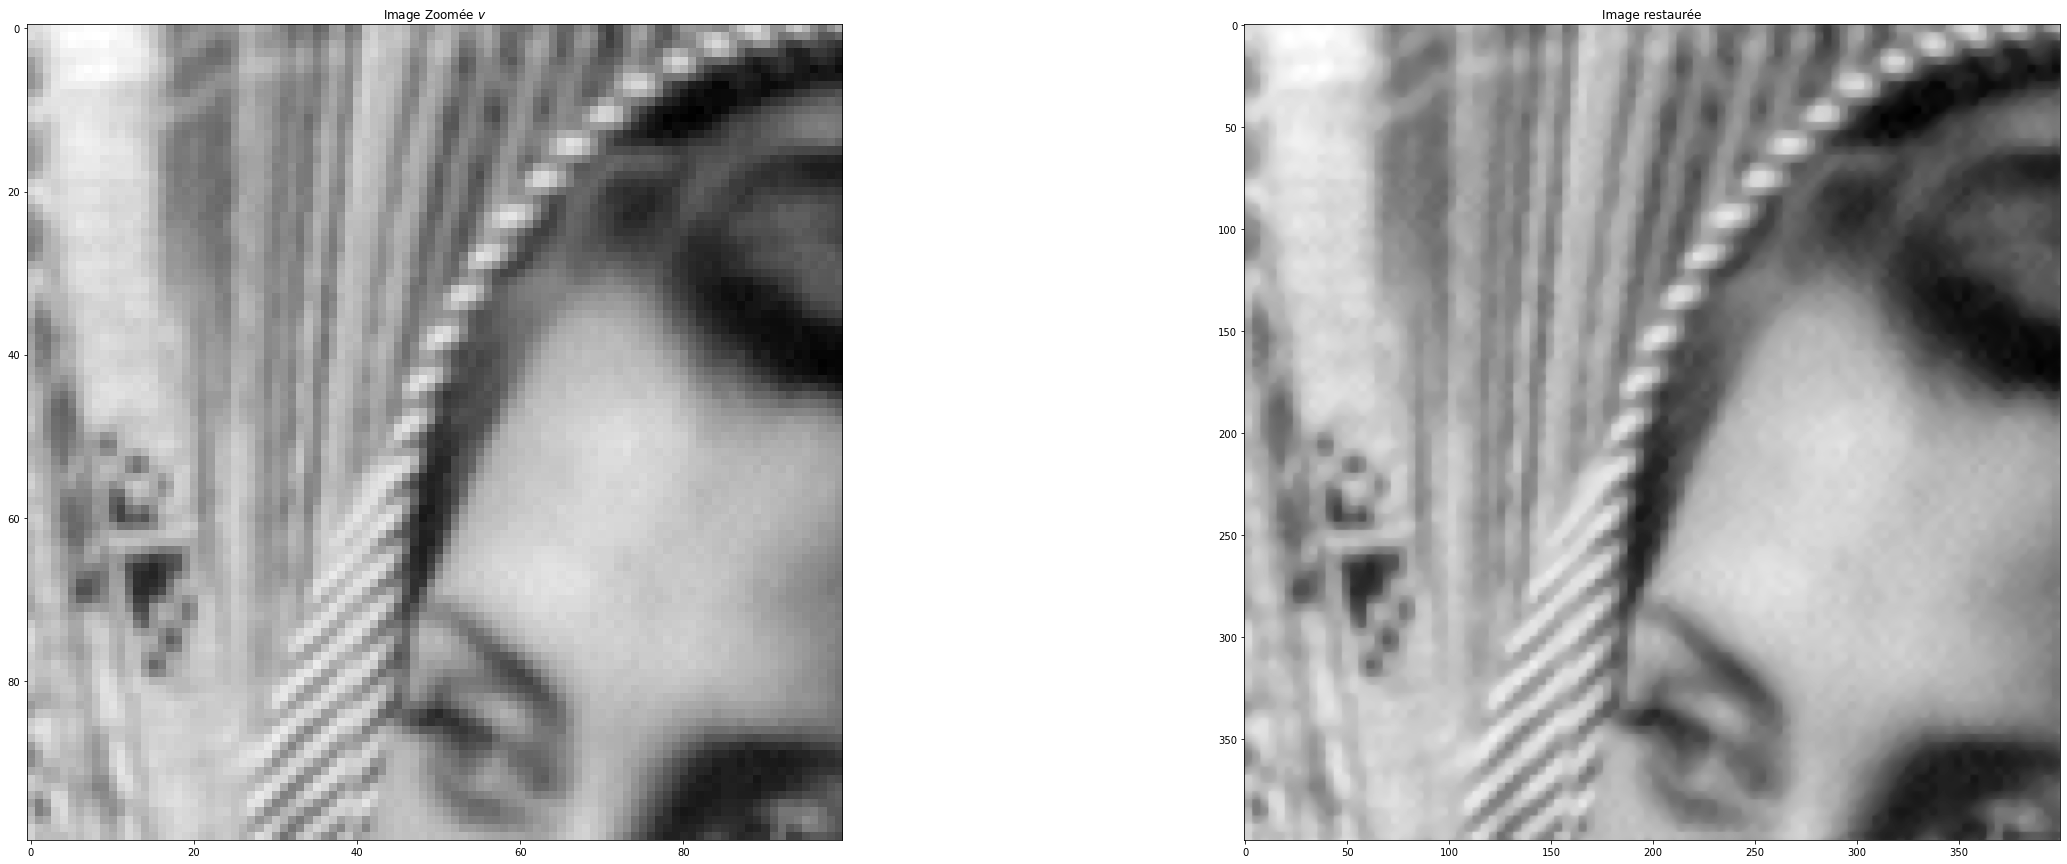

In [39]:
plt.figure(figsize = (40,15))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.title("Image Zoomée $v$")
plt.subplot(1,2,2)
plt.imshow(out_pc,cmap='gray')
plt.title("Image restaurée")
plt.show()

### Question 8
    Ici on construit la fonction qui calcul le pas d'Armijo

In [6]:
def TV1(out,beta):
    sx , sy = np.shape(out)
    tmpx = grad_x(out,0)
    tmpy = grad_y(out,0)
    
    tmp = phi(tmpx*tmpx+tmpy*tmpy,beta)
 
    return np.sum(np.abs(tmp))

In [15]:
def zoom_TV_armijo(v,K,nbIter):

    beta = 1

    out = (K*K)* echantillonne_image(v,K,1) # initialisation proche de la solution
    fonction = []
    #armijo
    i           = 1
    nbmax       = 15
    beta_armijo = 0.2
    sigma       = 0.5    

    for it in tqdm(range(nbIter),desc = 'Progression de l\'algorithme '):
        ti  = 1
        d   = grad_TV(out,beta)
        i   = 1
        while (TV1(out-(ti*d),beta) > -(( sigma*ti*(np.linalg.norm(d)**2) ) - TV1(out,beta)) ) :#and i <=nbmax :
            ti = ti*beta_armijo
            i += 1
        pas = ti
        out = out - pas * d
        out = projection(out,v,K)
        fonction = fonction+[TV1(out,beta)]
    return out, fonction

In [9]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [19]:
from tqdm import tqdm
K=4
nbIter = 100
v = u[0:100,0:100] 
out_a, func_a = zoom_TV_armijo(v,K,nbIter)

Progression de l'algorithme : 100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


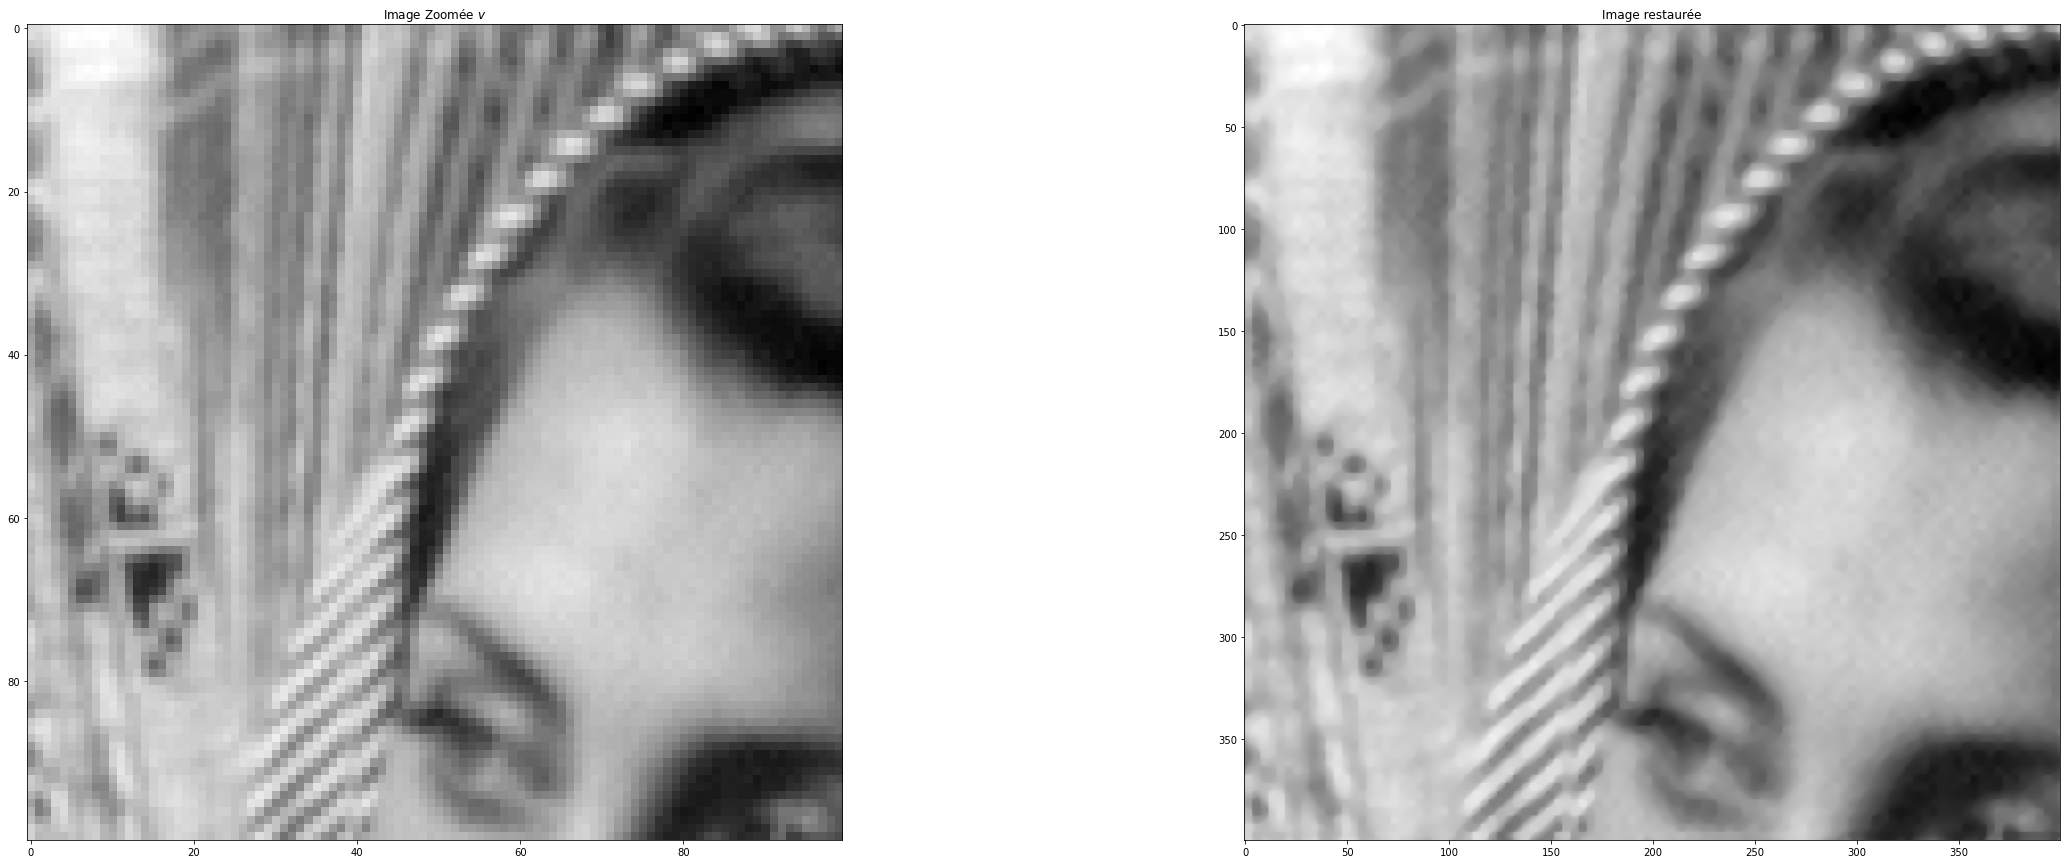

In [20]:
plt.figure(figsize = (40,15))
plt.subplot(1,2,1)
plt.imshow(v,cmap='gray')
plt.title("Image Zoomée $v$")
plt.subplot(1,2,2)
plt.imshow(out_a,cmap='gray')
plt.title("Image restaurée")
plt.show()

### Question 9 : Tourner les algorithmes pour différentes pas constante et pour le pas d'armijo

In [23]:
## Là on modifie la fonction Zoom_TV pour ajouter le pas comme parametre
def zoom_TV(v,K,nbIter,pas):
    func = []
    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)

    for it in range(nbIter):
        d = grad_TV(out,beta)
        out = out - pas * d
        out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', TV(out,beta) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        func += [TV(out,beta)]
        
    return out,func

In [24]:
# Paramètres d'entrée
K=4
beta = 1
pas  = [beta/4, beta/10, beta/16]
### Tourner L'algorithm pour différente pas constante pour 100 itération
Afficher = []
fonction = []
temp1 = 0
temp2 = 0
for i in pas[1:]:
    temp1, temp2 = zoom_TV(v,K,100, i)
    Afficher +=[temp1]
    fonction  +=[temp2]
    temp1 = 0
    temp2 = 0

iter =  0 fonction =  4.47174608848154 max contrainte =  1.1368683772161603e-13
iter =  1 fonction =  4.424993652233956 max contrainte =  1.4210854715202004e-13
iter =  2 fonction =  4.386122778342096 max contrainte =  1.1368683772161603e-13
iter =  3 fonction =  4.3528780996645375 max contrainte =  1.1368683772161603e-13
iter =  4 fonction =  4.323901262271171 max contrainte =  1.1368683772161603e-13
iter =  5 fonction =  4.298300915078096 max contrainte =  1.1368683772161603e-13
iter =  6 fonction =  4.275450017974937 max contrainte =  1.4210854715202004e-13
iter =  7 fonction =  4.254884143705057 max contrainte =  1.1368683772161603e-13
iter =  8 fonction =  4.236246346058868 max contrainte =  1.1368683772161603e-13
iter =  9 fonction =  4.219254854446253 max contrainte =  1.1368683772161603e-13
iter =  10 fonction =  4.203682789258236 max contrainte =  1.1368683772161603e-13
iter =  11 fonction =  4.189344672308857 max contrainte =  1.1368683772161603e-13
iter =  12 fonction =  4.1

In [26]:
## Tourner l'algo avec pas armijo et ajouter les résultats dans la liste d'avant
out_a,func_a = zoom_TV_armijo(v,K,nbIter)
Afficher +=[out_a]
fonction += [func_a]

Progression de l'algorithme : 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


In [40]:
Afficher +=[out_pc]
fonction += [func_pc]

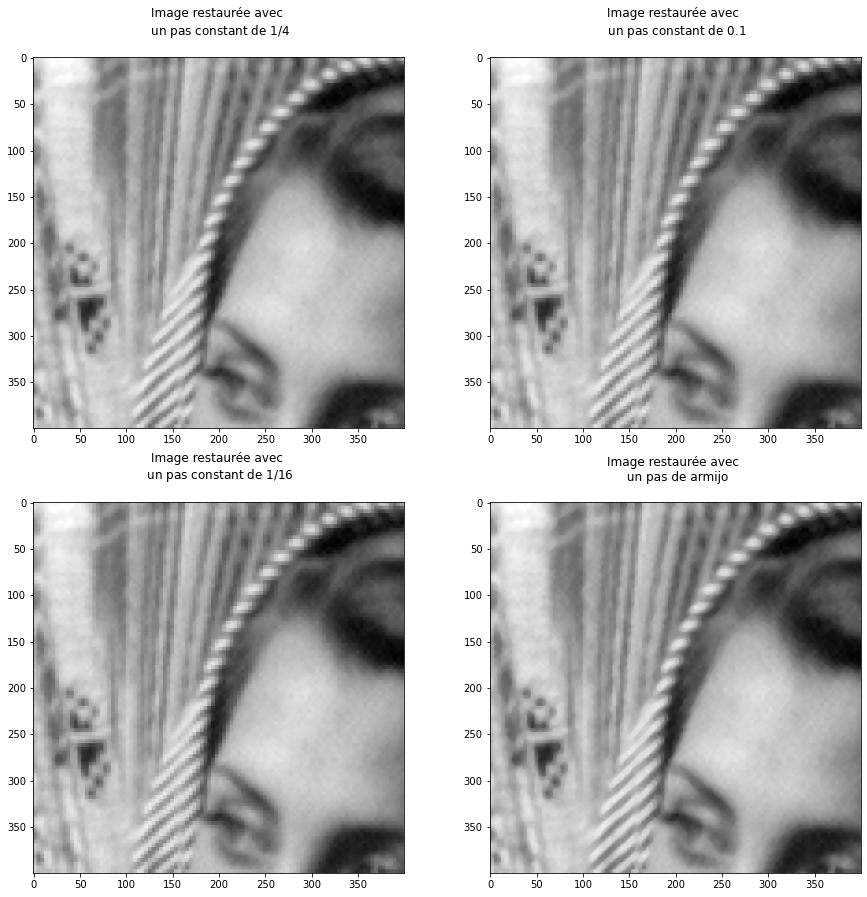

In [44]:
#Plot_images(Afficher,4,2,2,["Image restaurée avec \n un pas constant de $1/4$\n",\
                    # "Image restaurée avec \n un pas constant de $0.1$\n",\
                     #"Image restaurée avec \n un pas constant de $1/16$\n",\
                     #"#Image restaurée avec \n un pas de armijo\n"],\
                     #"Zoom\_TV pour les pas constants $1/4$ - $1/10$ - $1/16$ et le pas de Armijo",\
                     #0.945)
plt.figure(figsize = (15,15))
plt.subplot(2,2,1)
plt.title("Image restaurée avec \n un pas constant de $1/4$\n")
plt.imshow(Afficher[3],cmap='gray')
plt.subplot(2,2,2)
plt.title("Image restaurée avec \n un pas constant de $0.1$\n")
plt.imshow(Afficher[0],cmap='gray')
plt.subplot(2,2,3)
plt.title("Image restaurée avec \n un pas constant de $1/16$\n")
plt.imshow(Afficher[1],cmap='gray')
plt.subplot(2,2,4)
plt.title("Image restaurée avec \n un pas de armijo\n")
plt.imshow(Afficher[2],cmap='gray')


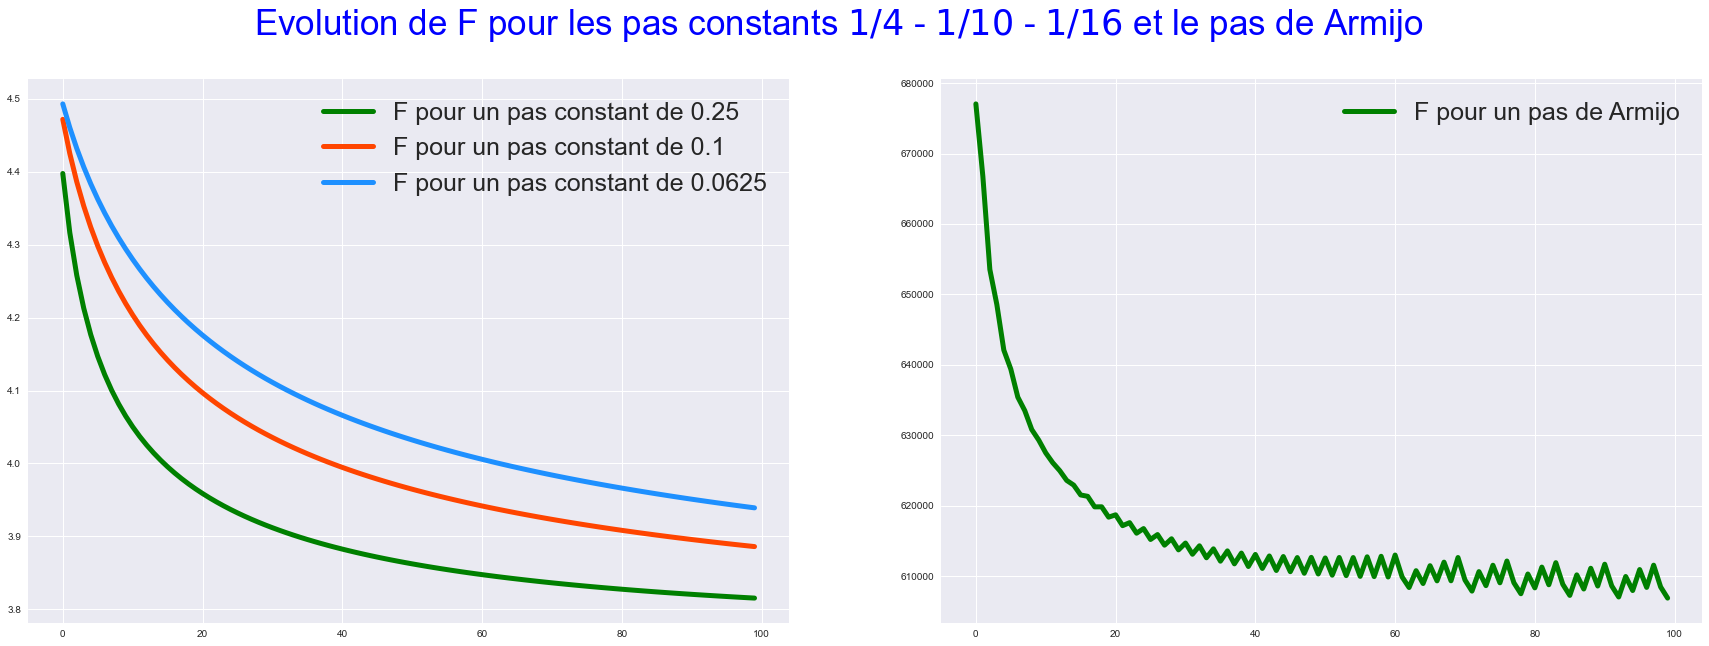

In [46]:
## Comparaison de Zoom_TV a pas constante et à pas d'armijo
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(30,10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.suptitle("Evolution de F pour les pas constants $1/4$ - $1/10$ - $1/16$ et le pas de Armijo",
                fontsize = 35,color = "blue")
    
    ax1.plot(fonction[3],"green",label ="F pour un pas constant de 0.25",linewidth = 5)
    ax1.plot(fonction[0],"orangered",label ="F pour un pas constant de 0.1",linewidth = 5)    
    ax1.plot(fonction[1],"dodgerblue",label ="F pour un pas constant de 0.0625",linewidth = 5)
    ax1.legend(fontsize = 25)

    ax2.plot(fonction[2],'green',label = "F pour un pas de Armijo",linewidth = 5)
    ax2.legend(fontsize = 25)
    
    plt.show()

#### Commentaire sur les résultats: 
Pour L'algorithme de descente avec un pas constant de 1/4, F prend sa plus petite valeur à l'itération 99 et vaut = 2.897432e+00

Pour L'algorithme de descente avec un pas constant de 0.1, F prend sa plus petite valeur à l'itération 99 et vaut = 2.907283e+00

Pour L'algorithme de descente avec un pas constant de 1/16, F prend sa plus petite valeur à l'itération 99 et vaut = 2.930467e+00

Pour L'algorithme de descente avec un pas de armijo, F prend sa plus petite valeur à l'itération 99 et vaut = 4.479944e+05

#### Conclusion
Les algorithmes de descente du gradient projeté à pas constant, d'armijo proposés dans cet exercice a le mérite de donner de bons résultats numériques, l'effet marches d'escalier est atténué. Ils présentent par contre l’inconvénient d’être coûteux en temps de calcul, avec l'algorithme de descente avec un pas de armijo atteignant plus vite le minimum mais prenant de plus grandes valeurs pour $F$ et rendant un meilleur résultat.

# Exercice 2 :

On considère maintenant, la fonctionnnelle suivante

$$F(w) = E(w) + \lambda \sum_{i,j=0}^{N-1} \left(Q(w)_{i,j}-v_{i,j}\right)^2$$

permettant de résoudre le problème $(P)$ par pénalisation. Pour une grande valeur de $\lambda = 10$

A cet effet, nous allons implémenter un algorithme du gradient à pas constant et à pas de armijo et pour se faire nous avons calculer le gradient de $F$ qui est donné par 

$$\nabla F(w) = \nabla TV_{\beta}(w) + 2\lambda Q^*Q(w)- 2\lambda Q^*(v)$$

Pour trouver le pas constant optimal, on suit le calcul fait en TD pour le TP1, on a donc,

$\left\|\nabla F(w)-\nabla F(w')\right\| = \left\|\nabla E(w)-\nabla E(w') + 2\lambda Q^*Q(w-w') + 2\lambda Q^*(v) - 2\lambda Q^*(v)  \right\|$

Comme indiqué plus haut d'après le  [cours, page 20](https://www.math.univ-toulouse.fr/~fmalgouy/MMIP/lecture5.pdf),  
$$\left\|\nabla E(w)-\nabla E(w')\right\| \leq \frac{8}{\sqrt{\beta}} \left\|w-w'\right\|$$

et donc d'après l'inégalité triangulaire  et le TD1 on a :

$\left\|\nabla F(w)-\nabla F(w')\right\| \leq \left(\frac{8}{\sqrt{\beta}} + 2\lambda \right) \left\|Q^*Q\right\| \left\|w-w'\right\| \leq \left(\frac{8}{\sqrt{\beta}} + 2\lambda \right) \left\|w-w'\right\|$

$\beta$ étant fixé à 1, on prend un pas constant de $\frac{1}{8+2\lambda}$

## Question 1:

In [176]:
def F(out,v,K,Lambda):
    beta = 1
    sx , sy = np.shape(out)
    data = np.linalg.norm((echantillonne_image(out,K,0)-v),ord=1)
    return (TV(out,beta)+(Lambda*data*data)/(sx*sy))
def grad_F(out,v,k,Lambda):
    beta = 1
    grad = grad_TV(out,beta) +2 * Lambda * (echantillonne_image(echantillonne_image(out,K,0)-v,K,1)) 
    return grad
    

In [177]:
def zoom_penalisation_pas_cte(v,K,nbIter,Lambda):
    beta = 1
    pas = beta/4
    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)
    Func =[]
    for it in range(nbIter):
        d = grad_F(out,v,K,Lambda)
        out = out - pas * d
        #out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', F(out,v,K,Lambda) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        Func.append(F(out,v,K,Lambda))
    return out,Func

iter =  0 fonction =  4.360863773810151 max contrainte =  0.23942108910624427
iter =  1 fonction =  4.248196994833871 max contrainte =  0.4713281177296835
iter =  2 fonction =  4.161643420770252 max contrainte =  0.6959424342175993
iter =  3 fonction =  4.09201788367571 max contrainte =  0.9134790142467324
iter =  4 fonction =  4.034482950208874 max contrainte =  1.1241478401211396
iter =  5 fonction =  3.9860745169311524 max contrainte =  1.3281539799472455
iter =  6 fonction =  3.9448207955054952 max contrainte =  1.5256977621906174
iter =  7 fonction =  3.909329612002712 max contrainte =  1.7169747735962488
iter =  8 fonction =  3.878578310752598 max contrainte =  1.9022018333685367
iter =  9 fonction =  3.8517887110819835 max contrainte =  2.0815493375169467
iter =  10 fonction =  3.8283526150098295 max contrainte =  2.2551462808866347
iter =  11 fonction =  3.8077851053332092 max contrainte =  2.4231579173220155
iter =  12 fonction =  3.7896909472546447 max contrainte =  2.5858658

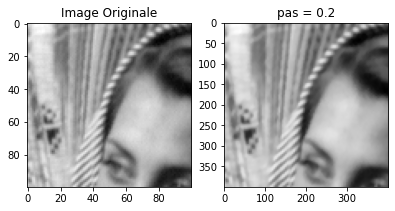

In [182]:
eps = 0.1
nbIter = 40
Lambda = 1
plt.figure(figsize = (10,7))
plt.subplot(2,3,1)
plt.title("Image Originale")
plt.imshow(v,cmap='gray')
for i in range(1):
    out1,Func1 = zoom_penalisation_pas_cte(v,K,nbIter,Lambda)
    plt.subplot(2,3,i+2)
    plt.title("pas = 0.2")
    plt.imshow(out1,cmap='gray')

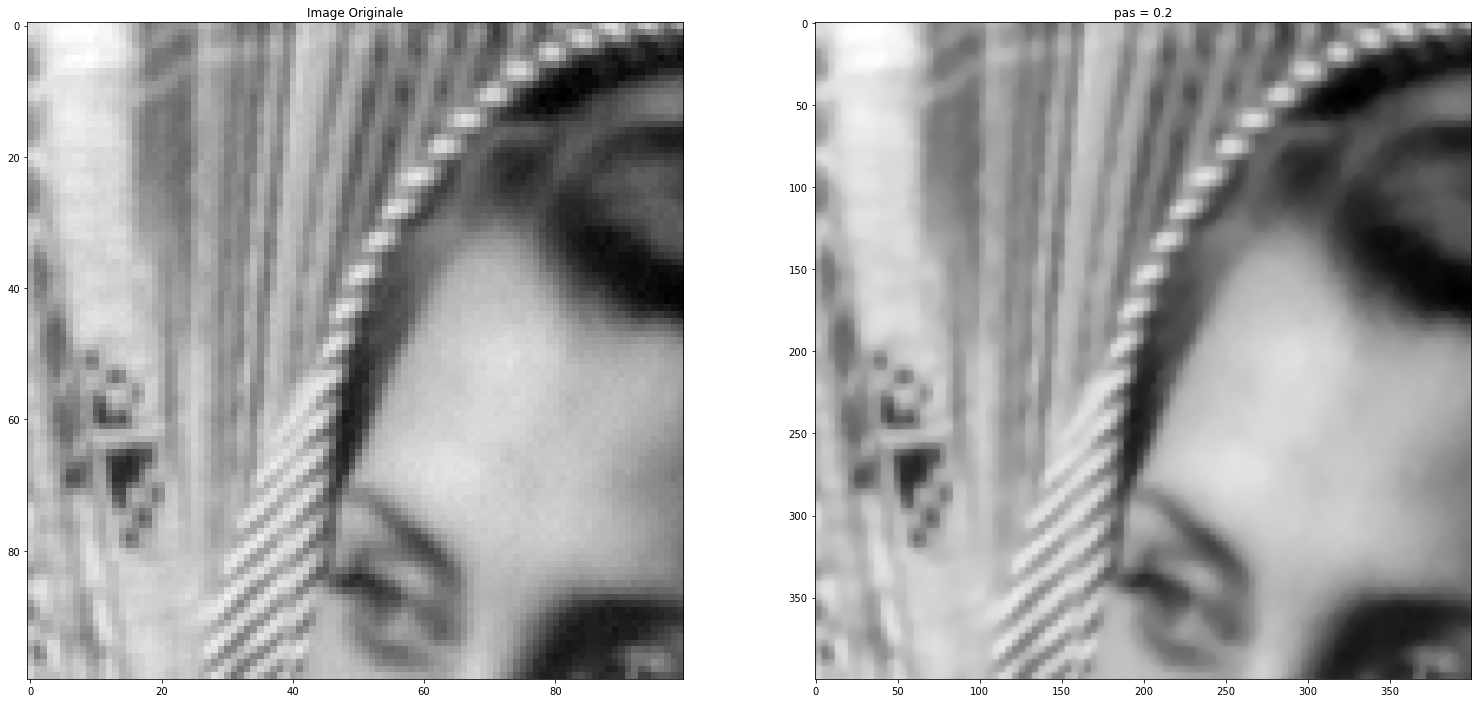

In [184]:
plt.figure(figsize = (40,30))
plt.subplot(2,3,1)
plt.title("Image Originale")
plt.imshow(v,cmap='gray')
for i in range(1):
    #out1,Func1 = zoom_penalisation_pas_cte(v,K,nbIter,Lambda)
    plt.subplot(2,3,i+2)
    plt.title("pas = 0.2")
    plt.imshow(out1,cmap='gray')

## Question 1 : avec pas Armijo

In [157]:
def F(out,v,K,Lambda):
    beta = 1
    sx , sy = np.shape(out)
    data = np.linalg.norm((echantillonne_image(out,K,0)-v),ord=1)
    return (TV1(out,beta)+(Lambda*data*data))

In [158]:
def armijo_F(pas,out,beta,c,v,K, Lambda):
    d = -grad_F(out,v,K, Lambda)
    out_till = out + pas*d 
    cond = F(out,v,K, Lambda) - F(out_till,v,K, Lambda) - c*pas* np.linalg.norm(grad_F(out,v,K, Lambda),ord = 1)**2
    #print(cond)
    i = 0
    while cond < 0: #and i<=15:
        pas = pas*0.1
        i = i+1
        out_till = out_till + pas*d 
        cond = F(out,v,K, Lambda) - F(out_till,v,K, Lambda) - c*pas* np.linalg.norm(grad_F(out,v,K, Lambda),ord = 1)**2
    return pas

In [159]:
def zoom_penalisation_armijoF(v,K,nbIter):
    beta = 1
    pas = 1
    c = 0.5
    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)
    sx , sy = np.shape(out)
    Func = []
    for it in range(nbIter):
        pas  = armijo_F(pas,out,beta,c,v,K, Lambda)
        #print(pas)
        d = grad_F(out,v,K, Lambda)
        out = out - pas * d
        #out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', F(out,v,K, Lambda)/(sx*sy) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        Func.append(F(out,v,K, Lambda)/(sx*sy)) 
    return out,Func

In [160]:
out2,Func2 = zoom_penalisation_armijoF(v,K,nbIter)

iter =  0 fonction =  4.456701940082027 max contrainte =  0.09576843564251192
iter =  1 fonction =  4.395711247933572 max contrainte =  0.19033525135876062
iter =  2 fonction =  4.343359460375713 max contrainte =  0.2837146898062599
iter =  3 fonction =  4.297335689828707 max contrainte =  0.37592078153339514
iter =  4 fonction =  4.256232162952217 max contrainte =  0.4669673814417479
iter =  5 fonction =  4.21911797554415 max contrainte =  0.5568681872867671
iter =  6 fonction =  4.185340957599952 max contrainte =  0.6456367511553367
iter =  7 fonction =  4.154405165053464 max contrainte =  0.7332864873140892
iter =  8 fonction =  4.125928263937787 max contrainte =  0.8198306777642443
iter =  9 fonction =  4.099604768579425 max contrainte =  0.9052824761770353
iter =  10 fonction =  4.0751852020657795 max contrainte =  0.989654910628758
iter =  11 fonction =  4.052462420831884 max contrainte =  1.0729608854360038
iter =  12 fonction =  4.031263301920775 max contrainte =  1.15521318232

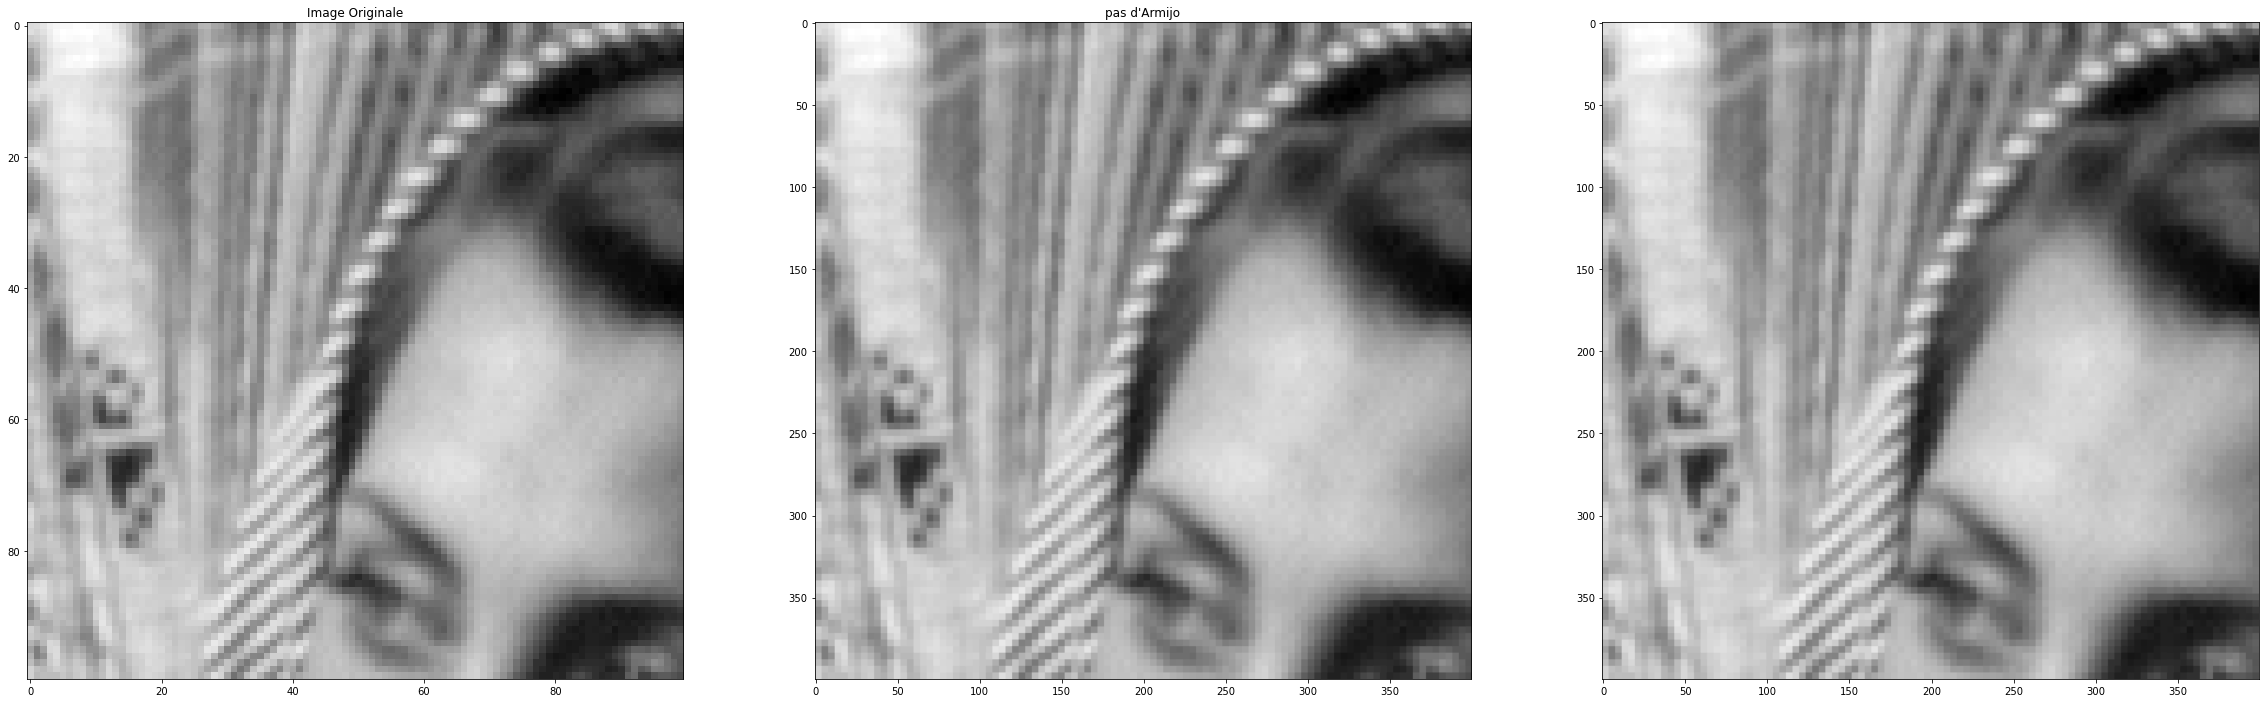

In [78]:
v = u[0:100,0:100] 
out_1 = (K*K)* echantillonne_image(v,K,1) 
plt.figure(figsize = (40,30))
plt.subplot(2,3,1)
plt.title("Image Originale")
plt.imshow(v,cmap='gray')
plt.subplot(2,3,2)
plt.title("pas d'Armijo")
plt.imshow(out1,cmap='gray')
plt.subplot(2,3,3)
#plt.title("pas d'Armijo")
plt.imshow(out_1,cmap='gray')

In [101]:
out2 = zoom_penalisation_armijoF(v,K,50)

-26839.02373703965
0.1
iter =  0 fonction =  4.456701940082027 max contrainte =  0.09576843564251192
2279.1346725550566
0.1
iter =  1 fonction =  4.395711247933572 max contrainte =  0.19033525135876062
2055.7974293903353
0.1
iter =  2 fonction =  4.343359460375713 max contrainte =  0.2837146898062599
1885.0626188284405
0.1
iter =  3 fonction =  4.297335689828707 max contrainte =  0.37592078153339514
1744.941845295707
0.1
iter =  4 fonction =  4.256232162952217 max contrainte =  0.4669673814417479
1612.1522572353251
0.1
iter =  5 fonction =  4.21911797554415 max contrainte =  0.5568681872867671
1474.6273208356984
0.1
iter =  6 fonction =  4.185340957599952 max contrainte =  0.6456367511553367
1336.1137288533891
0.1
iter =  7 fonction =  4.154405165053464 max contrainte =  0.7332864873140892
1185.2308404869582
0.1
iter =  8 fonction =  4.125928263937787 max contrainte =  0.8198306777642443
1052.5149688250194
0.1
iter =  9 fonction =  4.099604768579425 max contrainte =  0.9052824761770353

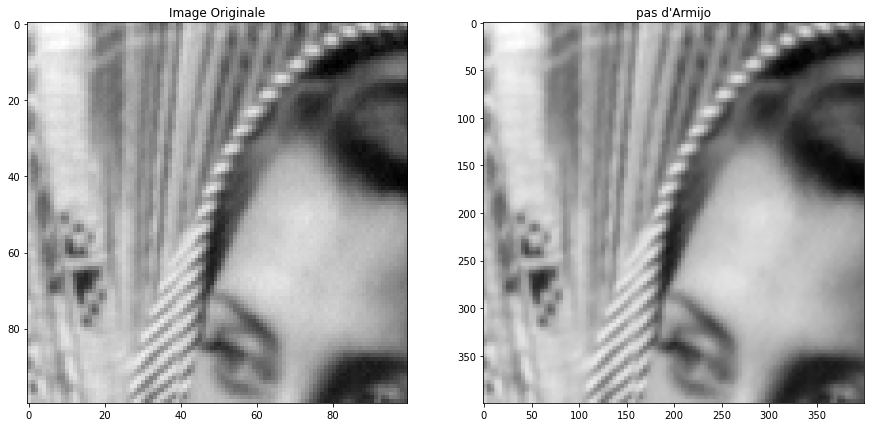

In [107]:
v = u[0:100,0:100] 
out_1 = (K*K)* echantillonne_image(v,K,1) 
plt.figure(figsize = (15,30))
plt.subplot(2,2,1)
plt.title("Image Originale")
plt.imshow(v,cmap='gray')
plt.subplot(2,2,2)
plt.title("pas d'Armijo")
plt.imshow(out2,cmap='gray')
#plt.subplot(2,3,3)
#plt.title("pas d'Armijo")
#plt.imshow(out_1,cmap='gray')

## Question 2
   ### Pas de la plus grand descente

In [161]:
def F(out,v,K,Lambda):
    beta = 1
    sx , sy = np.shape(out)
    data = np.linalg.norm((echantillonne_image(out,K,0)-v),ord=1)
    return (TV(out,beta)+(Lambda*data*data)/(sx*sy))

In [162]:
# Calcul du pas: pour cela on aura besoin de calculer la Hessien
def hessF(out,Lambda,beta,K,v):
    H=grad_TV(np.identity(out.shape[0]),beta)
    H+=2*Lambda*np.identity(out.shape[0])
    return(H)
def pgp(out,Lambda,beta,K,v):
    d=grad_F(out,v,K, Lambda)
    h=hessF(out,Lambda,beta,K,v)
    pas=np.vdot(d,d)/np.vdot(np.dot(h,d),d)
    return(pas)

In [163]:
def zoom_penalisation_pgp(v,K,nbIter):
    beta = 1
    pas = 1
    c = 0.5
    Func = []
    out = (K*K)* echantillonne_image(v,K,1)     # initialisation proche de la solution
#    out = np.zeros(K*np.shape(v))    # initialisation plus lointaine (pour tester)
    sx , sy = np.shape(out)
    for it in range(nbIter):
        pas  = pgp(out,Lambda,beta,K,v)
        d = grad_F(out,v,K, Lambda)
        out = out - pas * d
        #out = projection(out,v,K)
        print( 'iter = ', it , 'fonction = ', F(out,v,K, Lambda) ,\
              'max contrainte = ', np.abs(echantillonne_image(out,K,0)-v).max() )
        Func.append(F(out,v,K, Lambda))
    return out,Func

In [164]:
out3,Func3 = zoom_penalisation_pgp(v,K,nbIter)

iter =  0 fonction =  4.359116586841775 max contrainte =  0.24230938365529653
iter =  1 fonction =  4.234463962435754 max contrainte =  0.5022553135092949
iter =  2 fonction =  4.137709163291582 max contrainte =  0.7636596654662071
iter =  3 fonction =  4.060335126280898 max contrainte =  1.0217454327579674
iter =  4 fonction =  3.9971742082276047 max contrainte =  1.2743640885604464
iter =  5 fonction =  3.944867547567496 max contrainte =  1.5203801870034397
iter =  6 fonction =  3.9011171615573685 max contrainte =  1.7590502934061476
iter =  7 fonction =  3.864265690766145 max contrainte =  1.989984511994237
iter =  8 fonction =  3.833086343408223 max contrainte =  2.2128077388577765
iter =  9 fonction =  3.8066451797683167 max contrainte =  2.427190797485707
iter =  10 fonction =  3.7842165182060987 max contrainte =  2.632783711195586
iter =  11 fonction =  3.765242091265553 max contrainte =  2.8289504329583224
iter =  12 fonction =  3.7492576996737235 max contrainte =  3.0148193345

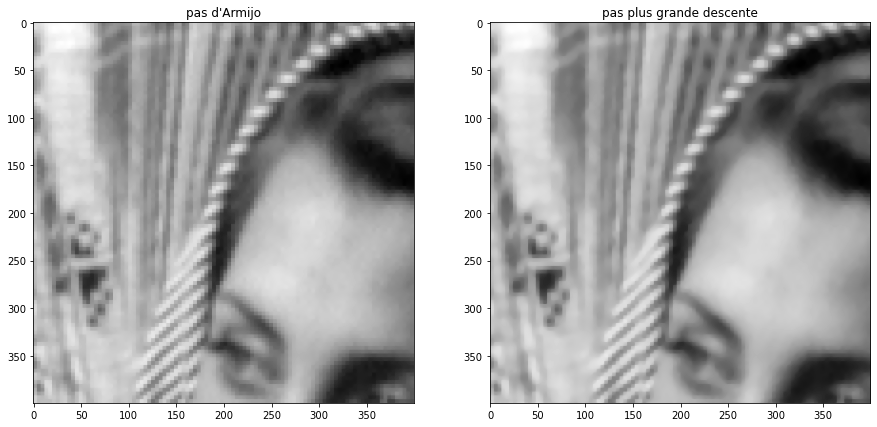

In [120]:
plt.figure(figsize = (15,30))
plt.subplot(2,2,1)
plt.title("pas d'Armijo")
plt.imshow(out2,cmap='gray')
plt.subplot(2,2,2)
plt.title("pas plus grande descente")
plt.imshow(out3,cmap='gray')

# Exercice 3 

## Question 1 :

In [50]:
def compute(img,sx,sy,m,n):
    temp = 0
    for mp in range(-1,2):
        for np in range(-1,2):
            temp += img[(m+mp)%sx,(n+np)%sy]
    return temp

def H(img):
    sx, sy = np.shape(img)
    out    = np.copy(img)
    for m in range(sx):
        for n in range(sy):
            out[m,n] = compute(img,sx,sy,m,n)
    return out

## Question 2 : 

Nous souhaitons minimiser une fonctionnelle par l'algorithme du gradient permettant de résoudre 

$$F(w) = TV_{\varepsilon}(w)+\lambda \|Hw-v\|^2$$

pour des valeurs de $\varepsilon$ et $\lambda > 0$

Pour se faire, nous devons calculer $\nabla F$ qui vaut :

$$ \nabla F = \nabla TV_{\varepsilon} + \lambda \nabla \|Hw-v\|^2$$

 - Avec $\nabla \|Hw-v\|^2$ donné par,

Soit $w,w' \in \mathbb{R}^{N^2}$

$$
\begin{aligned}
\left\|H(w+w')-u\right\|_{2}^2 &= \left \langle \left(Hw-u\right)+Hw',\left(Hw-u\right)+Hw'\right \rangle\\
&= \left \langle Hw-u,Hw-u\right \rangle + 2\left \langle Hw',Hw-u\right \rangle + \left \langle Hw',Hw'\right \rangle \\
&= \left\|Hw-u\right\|_{2}^2 + \left \langle w',2H^*\left(Hw-u\right)\right \rangle +o\left(\|w'\|\right)
\end{aligned}
$$
Où $H^*$ est l'adjoint de $H$.

On a donc 

$$ \nabla F = \nabla TV_{\varepsilon} + 2\lambda H^*\left(Hw-u\right)$$

 - On cherche maintenant l'adjoint $H^*$ de $ H $ :

Soit $w,w' \in \mathbb{R}^{N^2}$, on a

$$
\begin{aligned}
\left \langle Hw, w' \right \rangle &= \sum^N_{m,n = 1}\sum^1_{m',n' = -1}w_{m+m', n+n'} w'_{m,n} \quad (\text{on pose } m+m' = m_1 \text{ et } n+n' = n_1)\\
&= \sum^{N+1}_{m_1,n_1 = 0}\sum^1_{m',n' = -1}w_{m_1, n_1} w'_{m_1-m',n_1-n'}
\end{aligned}
$$

Par périodisation et puisque $(-m',-n') \in \{-1,0,1\}^2$ est équivalent à dire que $(m',n') \in \{-1,0,1\}^2$

$$
\begin{aligned}
\left \langle Hw, w'\right \rangle &= \sum^{N}_{m_1,n_1 = 1}\sum^1_{m',n' = -1}w_{m_1, n_1} w'_{m_1+m',n_1+n'}\\
&= \left \langle w, H^* w'\right \rangle = \left \langle w, H w'\right \rangle
\end{aligned}
$$

Donc $H$ est un opérateur autoadjoint.

On choisit également, un pas de $\dfrac{1}{\dfrac{8}{\sqrt{\varepsilon}} + 2\lambda}$ 

In [51]:
# Question 2 Algorithme du gradient à pas constant et à pas d'armijo
#####################################################################

def F3(out,v,eps,Lambda):
    sx , sy = np.shape(out)
    data = np.linalg.norm( H(out) - v, ord='fro') 
    return TV(out,eps)+( (Lambda * data*data)/(sx*sy) )

def grad_F3(out,v,eps,Lambda):

    temp  = H(out) - v
    temp1 = H(temp)
    grad  = grad_TV(out,eps) + ((2*Lambda)*temp1)
    return grad

###################### PAS CONSTANT ###########################

def gradient_descent_PC(v,eps,Lambda,nbIter):
    """Algorithme de descente du gradient utilisant une stratégie de 
       pas constant
    """

    pas = np.sqrt(eps)/(8+(2*Lambda*np.sqrt(eps)))
    out = np.copy(v)  
    fonction = []
    anim     = [out]
    for it in tqdm(range(nbIter),desc = 'Progression de l\'algorithme '):
        d = grad_F3(out,v,eps,Lambda)
        out      = out - pas * d
        fonction = fonction+[F3(out,v,eps,Lambda)]
        anim    += [out]   
    return out,fonction, anim

In [52]:
###### PAS D'ARMIJO #######

def F3_armijo(out,v,eps,Lambda):
    sx , sy = np.shape(out)
    data = np.linalg.norm( H(out) - v, ord='fro') 
    return TV1(out,eps)+(Lambda * data*data)


def gradient_descent_armijo(v,eps,Lambda,nbIter):
    out = np.copy(v) # initialisation proche de la solution
    fonction = []
    #armijo
    i           = 1
    nbmax       = 15
    beta_armijo = 0.2
    sigma       = 0.5    

    for it in tqdm(range(nbIter),desc = 'Progression de l\'algorithme '):
        ti  = 1
        d   = grad_F3(out,v,eps,Lambda)
        i   = 1
        while( F3_armijo(out-(ti*d),v,eps,Lambda) > -( ( sigma*ti*(np.linalg.norm(d)**2) ) - F3_armijo(out,v,eps,Lambda) ) ) and i <=nbmax :
            ti = ti*beta_armijo
            i += 1
        pas = ti
        out = out - pas * d
        fonction = fonction+[F3_armijo(out,v,eps,Lambda)]
    return out,fonction

## Question 3 

In [56]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:511]    # image de taille moyenne
v  = H(u) + np.random.normal(0,2,np.shape(u))

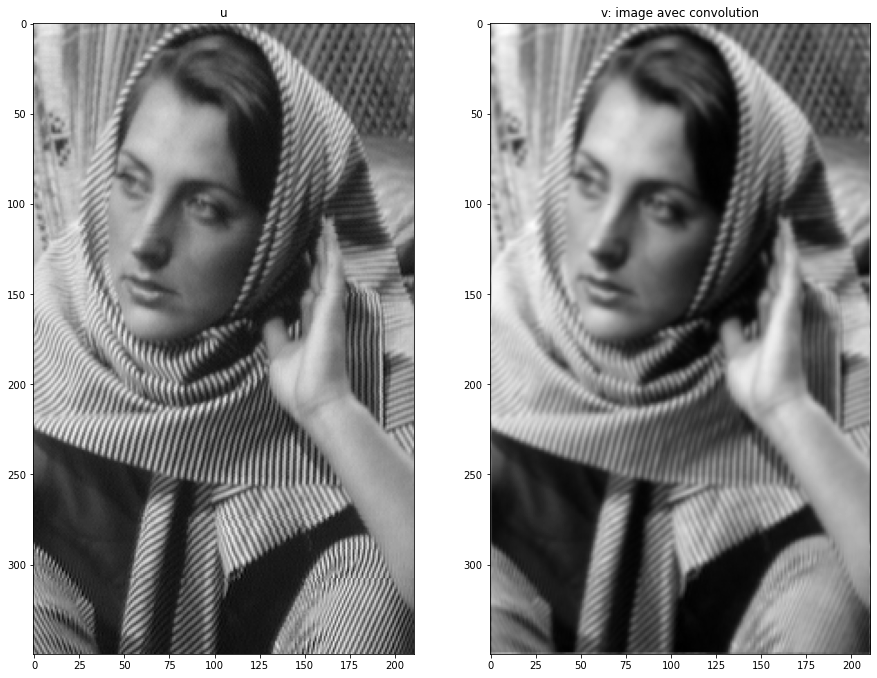

In [57]:
plt.figure(figsize = (15,30))
plt.subplot(2,2,1)
plt.title("u")
plt.imshow(u,cmap='gray')
plt.subplot(2,2,2)
plt.title("v: image avec convolution")
plt.imshow(v,cmap='gray')

In [60]:
Lambda = [0.1,1,10,100]
eps = 10**-2
w_exo3    = []
fonction  = []
animation = []
temp1 = 0
temp2 = 0
temp3 = 0
for i in Lambda:
    temp1, temp2, temp3 = gradient_descent_PC(v,eps,i,100)
    w_exo3    +=[temp1]
    fonction  +=[temp2]
    animation +=[temp3]
    temp1 = 0
    temp2 = 0
    temp3 = 0

Progression de l'algorithme : 100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


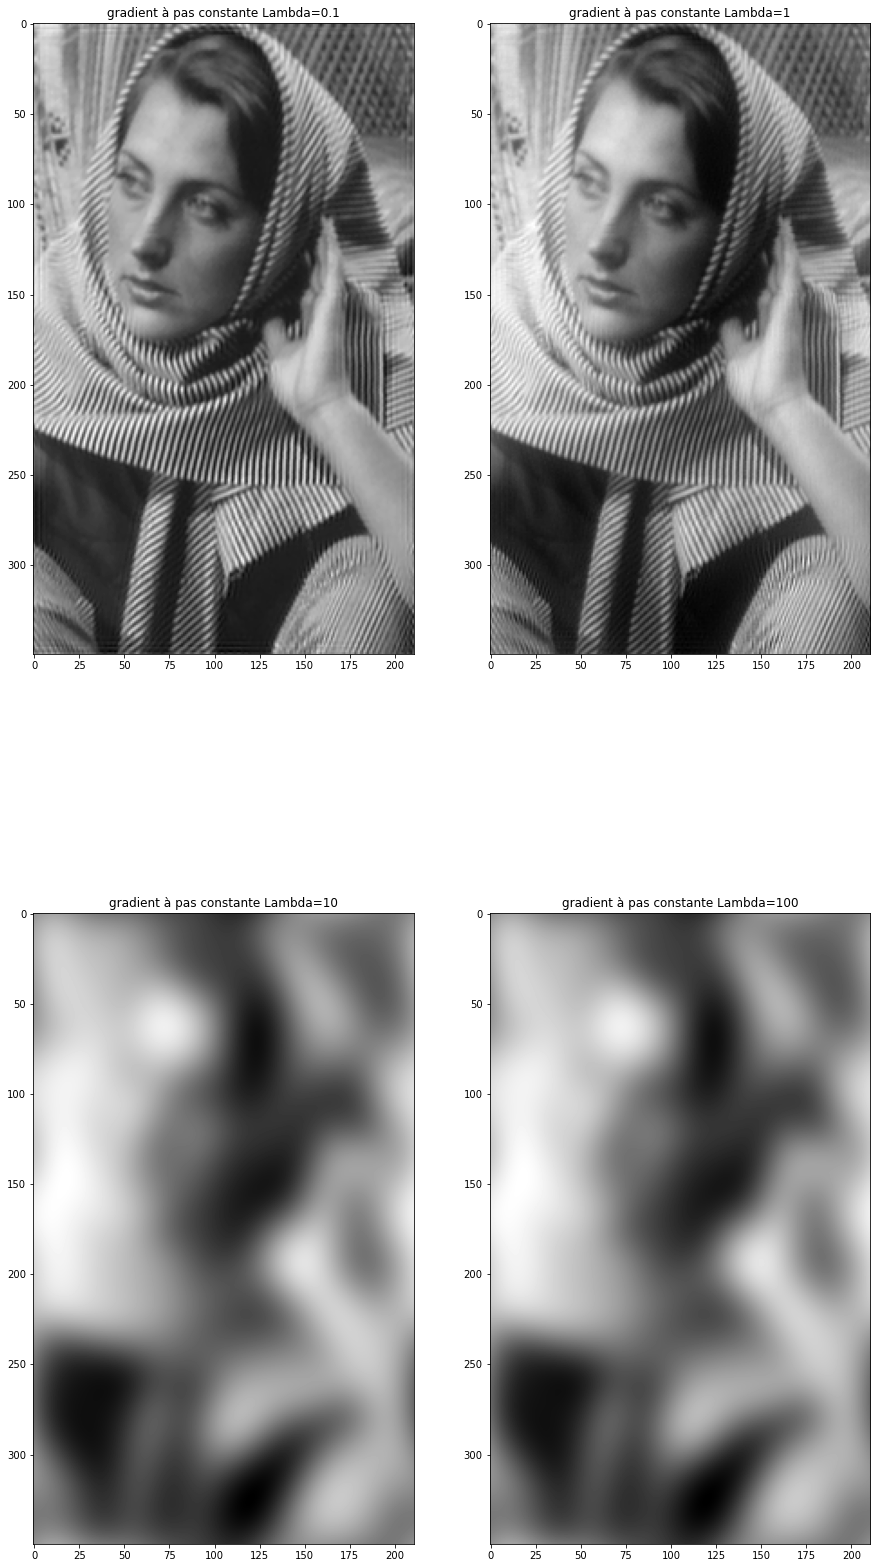

In [62]:
plt.figure(figsize = (15,30))
plt.subplot(2,2,1)
plt.title("Image Originale")
plt.imshow(u,cmap='gray')
plt.subplot(2,2,1)
plt.title("gradient à pas constante Lambda=0.1")
plt.imshow(w_exo3[0],cmap='gray')
plt.subplot(2,2,2)
plt.title("gradient à pas constante Lambda=1")
plt.imshow(w_exo3[1],cmap='gray')
plt.subplot(2,2,3)
plt.title("gradient à pas constante Lambda=10")
plt.imshow(w_exo3[2],cmap='gray')
plt.subplot(2,2,4)
plt.title("gradient à pas constante Lambda=100")
plt.imshow(w_exo3[3],cmap='gray')

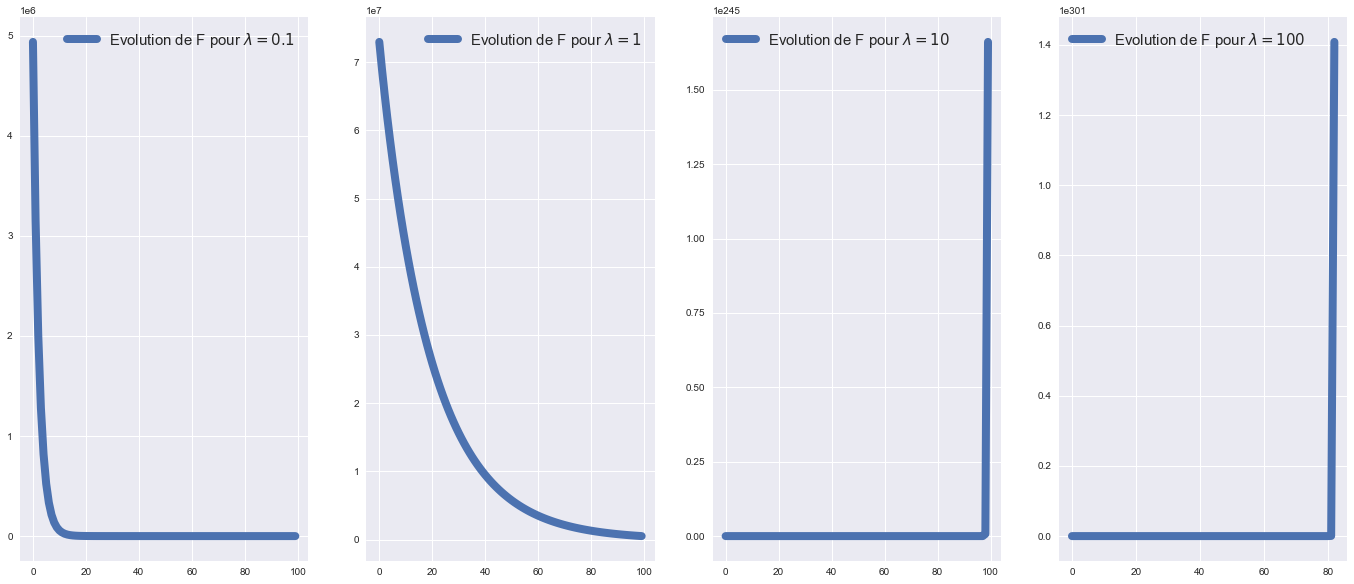

In [67]:
with plt.style.context('seaborn'):

    fig =plt.figure(figsize=(30,10))
    ax8 = fig.add_subplot(152)
    ax9 = fig.add_subplot(153)
    ax10 = fig.add_subplot(154)
    ax11 = fig.add_subplot(155)
    
    ax8.plot(fonction[0],linewidth = 8,\
             label = "Evolution de F pour $\lambda = 0.1$")
    ax8.legend(fontsize=15)
    
    ax9.plot(fonction[1],linewidth = 8,\
            label ="Evolution de F pour $\lambda = 1$")
    ax9.legend(fontsize=15)

    ax10.plot(fonction[2],linewidth = 8,\
            label ="Evolution de F pour $\lambda = 10$")
    ax10.legend(fontsize=15)

    ax11.plot(fonction[3],linewidth = 8,\
            label ="Evolution de F pour $\lambda = 100$")
    ax11.legend(fontsize=15)
    
    plt.show()


In [68]:
w_armijo   = []
fonction_armijo = []
temp1           = 0
temp2           = 0
for i in Lambda:
    temp1, temp2     = gradient_descent_armijo(v,eps,i,20)
    w_armijo   += [temp1]
    fonction_armijo += [temp2]
    temp1            = 0
    temp2            = 0

Progression de l'algorithme : 100%|██████████| 20/20 [03:04<00:00,  9.25s/it]


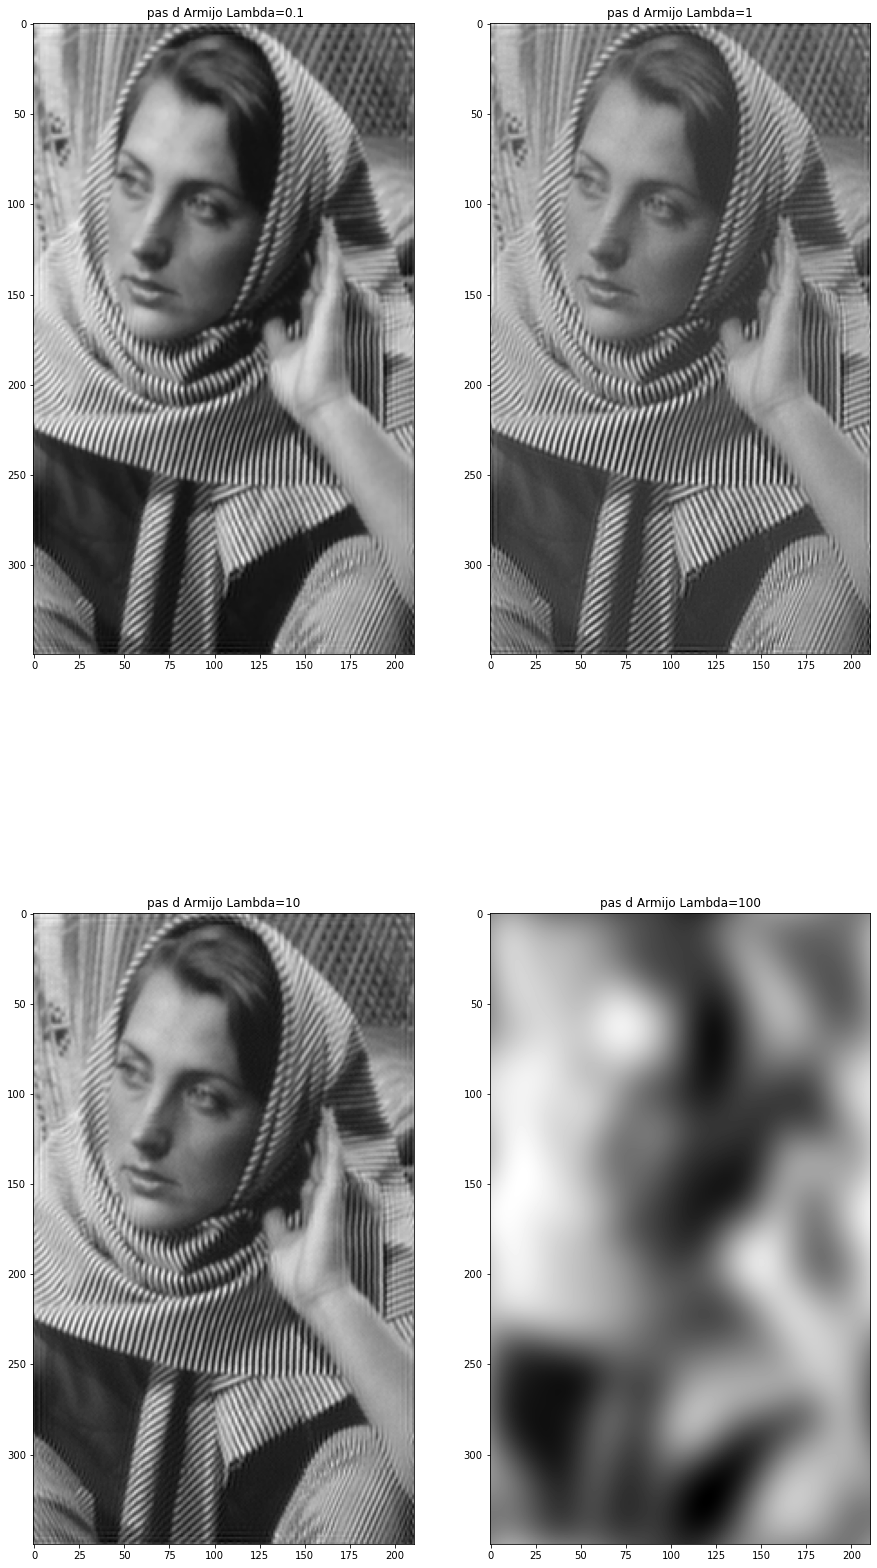

In [69]:
plt.figure(figsize = (15,30))
plt.subplot(2,2,1)
plt.title("Image Originale")
plt.imshow(u,cmap='gray')
plt.subplot(2,2,1)
plt.title(" pas d Armijo Lambda=0.1")
plt.imshow(w_armijo[0],cmap='gray')
plt.subplot(2,2,2)
plt.title("pas d Armijo Lambda=1")
plt.imshow(w_armijo[1],cmap='gray')
plt.subplot(2,2,3)
plt.title("pas d Armijo Lambda=10")
plt.imshow(w_armijo[2],cmap='gray')
plt.subplot(2,2,4)
plt.title("pas d Armijo Lambda=100")
plt.imshow(w_exo3[3],cmap='gray')

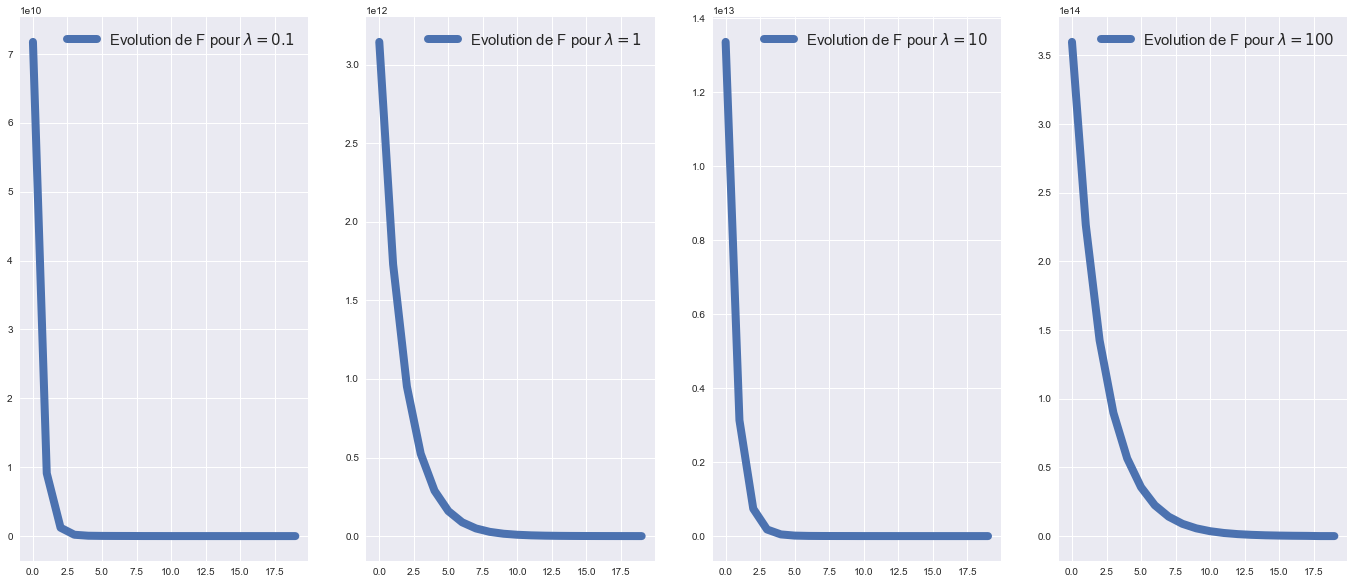

In [70]:
with plt.style.context('seaborn'):

    fig =plt.figure(figsize=(30,10))
    ax8 = fig.add_subplot(152)
    ax9 = fig.add_subplot(153)
    ax10 = fig.add_subplot(154)
    ax11 = fig.add_subplot(155)
    
    ax8.plot(fonction_armijo[0],linewidth = 8,\
             label = "Evolution de F pour $\lambda = 0.1$")
    ax8.legend(fontsize=15)
    
    ax9.plot(fonction_armijo[1],linewidth = 8,\
            label ="Evolution de F pour $\lambda = 1$")
    ax9.legend(fontsize=15)

    ax10.plot(fonction_armijo[2],linewidth = 8,\
            label ="Evolution de F pour $\lambda = 10$")
    ax10.legend(fontsize=15)

    ax11.plot(fonction_armijo[3],linewidth = 8,\
            label ="Evolution de F pour $\lambda = 100$")
    ax11.legend(fontsize=15)
    
    plt.show()